# Chapter 14. Simple Linear Regression

In [19]:
from __future__ import division
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
from linear_algebra import vector_subtract
from statistics import mean, correlation, standard_deviation, de_mean
from gradient_descent import minimize_stochastic
import math, random

In Chapter 5, we used the `correlation()` function to measure the strength of the linear relationship between two variables.  
For most applications, knowing that such a linear relationship exists isn't enough.  
We'll want to be able to understand the nature of the relationship.  
This is where we'll use [simple linear regression](https://en.wikipedia.org/wiki/Simple_linear_regression).

## The Model

Recall that we were investigating the relationship between a DataSciencester user's number of friends and the amount of time that he spent on the site each day.  
Let's assume that you've convinced yourself that having more friends *causes* people to spend more time on the site, rather than one of the alternative explanations we discussed.  
The VP of Engagement asks you to build a model describing this relationship.  
Since you found a pretty strong linear relationship, a natural place to start is with a linear model.  
In particular, you hypothesize that there are constants $\alpha$ (alpha) and $\beta$ (beta) such that:  

$\Large {y_i} = {\beta x_i}+{\alpha}+{\epsilon_i}$  

where 
- $y_i$ is the number of minutes user $i$ spends on the site daily, 
- $x_i$ is the number of friends user $i$ has, and 
- $\epsilon_i$ is a (hopefully small) error term representing the fact that there are other factors not accounted for by this simple model.

Assuming we've determined such an `alpha` and `beta`, then we make predictions with:

In [20]:
def predict(alpha, beta, x_i):
    return beta * x_i + alpha

How do we choose `alpha` and `beta`?  
Well, any choice of `alpha` and `beta` gives us a predicted output for each input `x_i`.  
Since we know the actual output `y_i` we can calculate the error for each pair:

In [21]:
def error(alpha, beta, x_i, y_i):
    """ the error from predicting beta * x_i + alpha when the actual value is y_i """
    return y_i - predict(alpha, beta, x_i)

What we'd really like to know is the total error over the entire data set.  
But we don't want to just add the errors -- if the prediction for `x_i` is too high and the prediction for `x_2` is too low, the errors may just cancel out.  
Instead, we add up the *squared* errors:

In [22]:
def sum_of_squared_errors(alpha, beta, x, y):
    return sum(error(alpha, beta, x_i, y_i) ** 2 for x_i, y_i in zip(x, y))

The *least squares solution* is to choose the `alpha` and `beta` that make `sum_of_squared_errors` as small as possible.

Using calculus (or tedious algebra), the error-minimizing alpha and beta are given by:

In [23]:
def least_squares_fit(x, y):
    """ given training values for x and y, find the least-squares values of alpha and beta """
    beta = correlation(x, y) * standard_deviation(y) / standard_deviation(x)
    alpha = mean(y) - beta * mean(x)
    return alpha, beta

Without going through the exact mathematics, let's think about why this might be a reasonable solution.  
The choice of `alpha` says that when we see the average value of the independent variable `x`, we predict the average value of the dependent variable `y`.  
The choice of `beta` means that when the input value increases by `standard_deviation(x)`, the prediction increases by `correlation(x, y)` $\;*\;$ `standard_deviation(y)`.  
In the case when `x` and `y` are perfectly correlated, a one-standard-deviation increase in `x` results in a one-standard-deviation-of-`y` increase in the prediction.  
When they are perfectly anti-correlated, the increase in `x` results in a *decrease* in the prediction.  
And when the correlation is zero, `beta` is zero, which means that changes in `x` don't affect the prediction at all.

As an example, let's apply this to the outlier-less data from Chapter 5:

In [24]:
num_friends = [100,49,41,40,25,21,21,19,19,18,18,16,15,15,15,15,14,14,13,13,13,13,12,12,11,10,10,10,10,10,10,10,10,
               10,10,10,10,10,10,10,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,8,8,8,8,8,8,8,8,8,8,8,8,8,7,7,7,7,7,7,7,7,
               7,7,7,7,7,7,7,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,4,4,4,
               4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,2,2,2,2,2,2,2,2,2,2,2,2,
               2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]
daily_minutes = [1,68.77,51.25,52.08,38.36,44.54,57.13,51.4,41.42,31.22,34.76,54.01,38.79,47.59,49.1,27.66,41.03,
                 36.73,48.65,28.12,46.62,35.57,32.98,35,26.07,23.77,39.73,40.57,31.65,31.21,36.32,20.45,21.93,26.02,
                 27.34,23.49,46.94,30.5,33.8,24.23,21.4,27.94,32.24,40.57,25.07,19.42,22.39,18.42,46.96,23.72,26.41,
                 26.97,36.76,40.32,35.02,29.47,30.2,31,38.11,38.18,36.31,21.03,30.86,36.07,28.66,29.08,37.28,15.28,
                 24.17,22.31,30.17,25.53,19.85,35.37,44.6,17.23,13.47,26.33,35.02,32.09,24.81,19.33,28.77,24.26,
                 31.98,25.73,24.86,16.28,34.51,15.23,39.72,40.8,26.06,35.76,34.76,16.13,44.04,18.03,19.65,32.62,
                 35.59,39.43,14.18,35.24,40.13,41.82,35.45,36.07,43.67,24.61,20.9,21.9,18.79,27.61,27.21,26.61,29.77,
                 20.59,27.53,13.82,33.2,25,33.1,36.65,18.63,14.87,22.2,36.81,25.53,24.62,26.25,18.21,28.08,19.42,
                 29.79,32.8,35.99,28.32,27.79,35.88,29.06,36.28,14.1,36.63,37.49,26.9,18.58,38.48,24.48,18.95,33.55,
                 14.24,29.04,32.51,25.63,22.22,19,32.73,15.16,13.9,27.2,32.01,29.27,33,13.74,20.42,27.32,18.23,35.35,
                 28.48,9.08,24.62,20.12,35.26,19.92,31.02,16.49,12.16,30.7,31.22,34.65,13.13,27.51,33.2,31.57,14.1,
                 33.42,17.44,10.12,24.42,9.82,23.39,30.93,15.03,21.67,31.09,33.29,22.61,26.89,23.48,8.38,27.81,32.35,
                 23.84]
outlier = num_friends.index(100)  # index of outlier
num_friends_good = [x for i, x in enumerate(num_friends) if i != outlier]
daily_minutes_good = [x for i, x in enumerate(daily_minutes) if i != outlier]

alpha, beta = least_squares_fit(num_friends_good, daily_minutes_good)
print "alpha: " + str(alpha) + ",  beta: " + str(beta)

alpha: 22.9475524135,  beta: 0.903865945606


Our model says that we expect a user with `n` friends to spend 22.95 + `n` $\;*\;$ 0.903 minutes on the site each day.  
That is, we predict that a user with no friends on DataSciencester would still spend about 23 minutes a day on the site, and for each additional friend, we would expect a user to spend nearly a minute more on the site each day.  
Let's plot the prediction line to get a sense of how well the model fits the observed data.

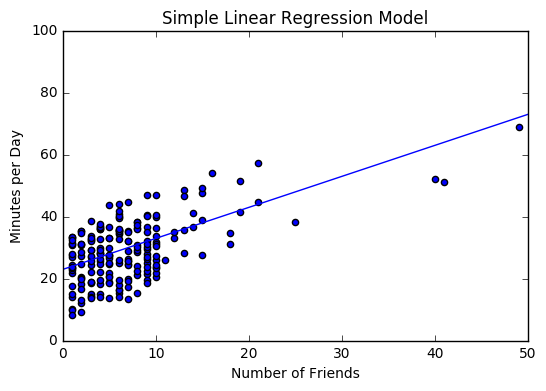

In [25]:
# This plot approximates the one shown in Figure 14.1, but I'm not sure about the numbers.
plt.scatter(num_friends_good, daily_minutes_good)
xs = [(i + alpha) for i, _ in enumerate(daily_minutes_good)]
plt.plot(xs)
plt.axis([0, 50, 0, 100])
plt.title("Simple Linear Regression Model")
plt.xlabel("Number of Friends")
plt.ylabel("Minutes per Day")
plt.show()

Now we need a better way to figure out how well the model fits the data than just staring at a graph.  
A common measure is the [coefficient of determination](https://en.wikipedia.org/wiki/Coefficient_of_determination), aka *R-squared*, which measures the fraction of the total variation in the dependent variable that is captured by the model:

In [26]:
def total_sum_of_squares(y):
    """ the total squared variation of y_i's from their mean """
    return sum(v ** 2 for v in de_mean(y))

def r_squared(alpha, beta, x, y):
    """ the fraction of variation in y captured by the model, which equals
        1 - the fraction of variation in y not captured by the model """
    return 1.0 - (sum_of_squared_errors(alpha, beta, x, y) / total_sum_of_squares(y))

r_squared(alpha, beta, num_friends_good, daily_minutes_good)

0.3291078377836305

We chose the `alpha` and `beta` that minimized the sum of the squared prediction errors.  
One linear model we could have chosen is "always predict `mean(y)`" (corresponding to `alpha = mean(y)` and `beta = 0`), whose sum of squared errors exactly equals its total sum of squares.  
This means an R-squared of zero, which indicates a model that performs no better than just predicting the mean.  
The least squares model must be at least as good as that one, which means that the sum of squared errors is *at most* the total sum of squares, which in turn means that the R-squared must be at least zero.  
Furthermore, the sum of squared errors must be at least 0, which means that the R-squared can be at most 1.  
The higher the number, the better the model fits the data.  
Here we calculated an R-squared of 0.329, which tells us that our model doesn't fit the data very well, and that there are other factors at work.

## Using Gradient Descent

If we write `theta = [alpha, beta]`, then we can also solve this using gradient descent:

In [27]:
def squared_error(x_i, y_i, theta):
    alpha, beta = theta
    return error(alpha, beta, x_i, y_i) ** 2

def squared_error_gradient(x_i, y_i, theta):
    alpha, beta = theta
    return [-2 * error(alpha, beta, x_i, y_i),        # alpha partial derivative
            -2 * error(alpha, beta, x_i, y_i) * x_i]  # beta partial derivative

random.seed(0)
theta = [random.random(), random.random()]
alpha, beta = minimize_stochastic(squared_error,
                                  squared_error_gradient,
                                  num_friends_good,
                                  daily_minutes_good,
                                  theta,
                                  0.0001)
print "alpha: " + str(alpha) + ",  beta: " + str(beta)

alpha: 22.9321291095,  beta: 0.905351505509


## Maximum Likelihood Estimation

Why choose least squares?  
One justification involves [maximum likelihood estimation](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation).  

Image that we have a sample $v_1, v_2, \ldots, v_n$ that comes from a distribution that depends on some unknown parameter $\large \theta$:  

$\Large p(v_1, \ldots, v_n \;|\; \theta)$  

If we didn't know theta, we could turn around and think of this quantity as the *likelihood* of $\large\theta$ given the sample:  

$\Large L(\theta\;|\;v_1,\ldots,v_n)$

Using this approach, the most likely $\large\theta$ is the value that maximizes this likelihood function; that is, the value that makes the observed data the most probable.  
In the case of a continuous distribution, in which we have a probability distribution function rather than a probability mass function, we can do the same thing.

Back to regression.  
One assumption that's often made about the simple regression model is that the regression errors are normally distributed with mean $\mu$ 0 and some (known) standard deviation $\sigma$.  
If that is the case, then the likelihood based of seeing a pair $(x_i,\;y_i)$ is:  

$\large L(\alpha,\;\beta\;|\;x_i,\;y_i,\;\sigma) = \frac{1}{\sqrt{2\pi\sigma}}exp\;(\;-\;(y_i\;-\;\alpha\;-\;\beta x_i)^2\;/\;2\sigma ^2)$  

The likelihood based on the entire data set is the product of the individual likelihoods, which is largest precisely when `alpha` $\normalsize\alpha$ and `beta` $\normalsize\beta$ are chosen to minimize the sum of squared errors.  
In this case (and with these assumptions), minimizing the sum of squared errors is equivalent to maximizing the likelihood of the observed data.  

## For Further Exploration  

Move on to Chapter 15 and [multiple regression](https://en.wikipedia.org/wiki/Regression_analysis#General_linear_model)